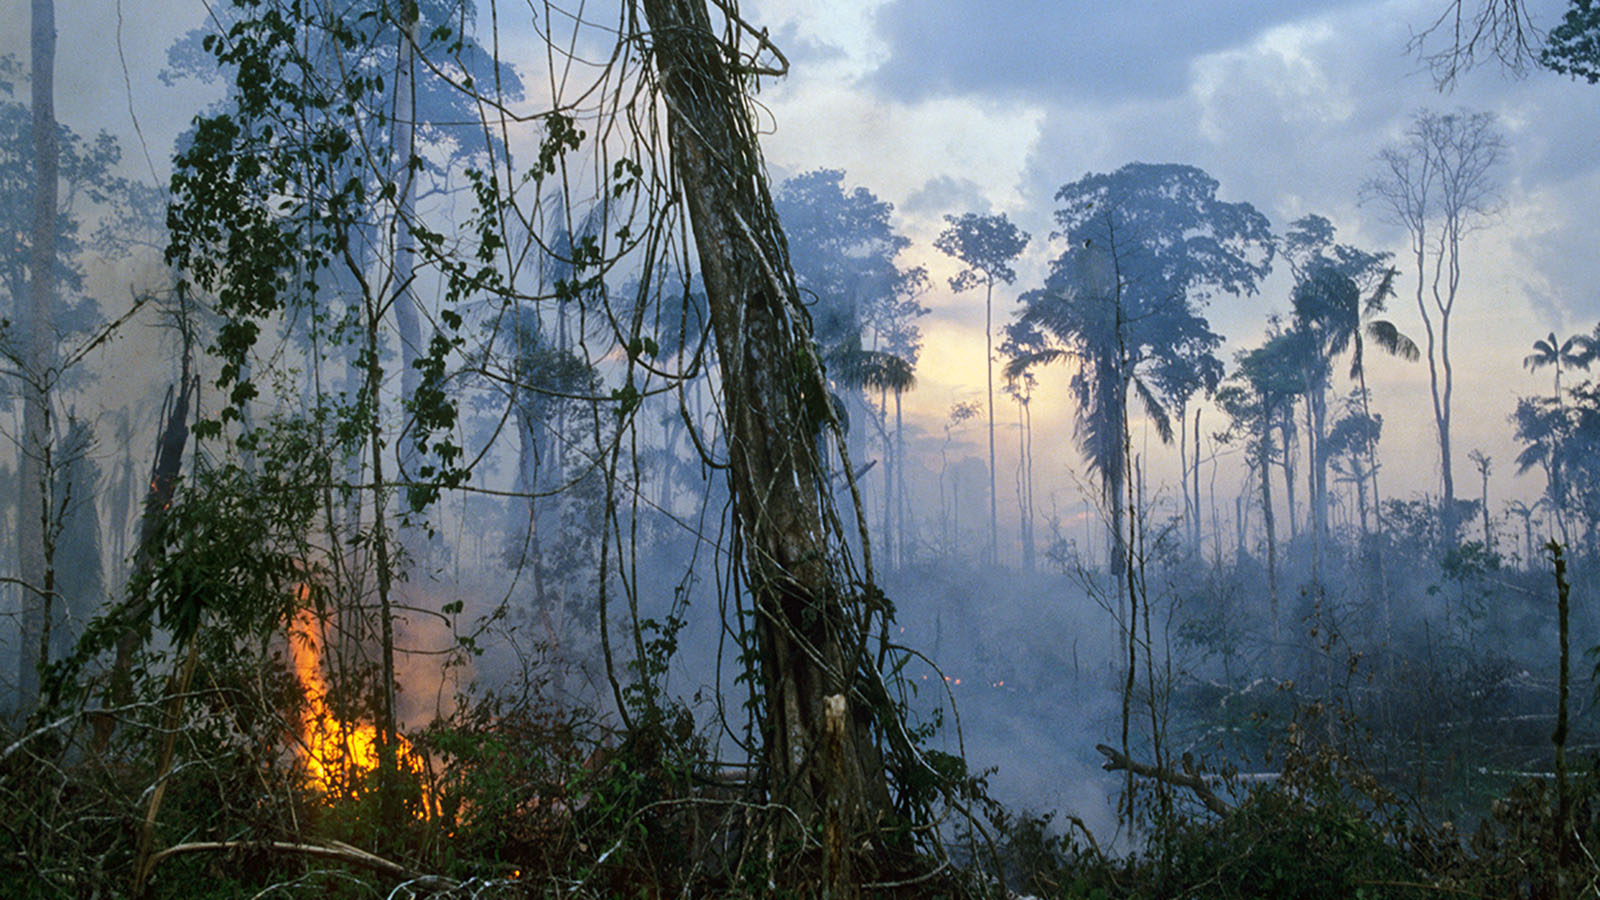

Forest depletion is among the leading factors exacerbating climate change. In the amazon basin, activities such as farming, selective logging, mining, and road construction lead to deforestation which leads to devastating effects on planet’s greenhouse gas emissions. 

Trees absorb CO2 when they are growing, but dead trees release it back to the atmosphere. New studies suggest that one fifth of the Amazon rainforest is emitting more CO2 than it absorbs.

In this project, you _____________________(fill this part with outline after the project is compelete)

use multilabel image classification techniques on a dataset consisting of satellite images from the amazon rainforest to help policy-makers and other stakeholders understand atmospheric conditions and the effects of human activity in the amazon basin. 
After completing this project you will be able to process large amounts of visual satellite data, understand multi-label classification tasks and develop a baseline AI model from scratch then use various techniques to improve model performance. 

Your AI model will be helpful to NGOs and goverments that are trying to identify areas that destructive human activity is occuring. They will be able to implement the right policies based on how often each phenomena is detected and they can aim their restorative efforts towards the areas that you detect.

The first step is to understand the problem: 

*   What problem do we want to solve?
*   What kind of data do we have?



# The Planet Dataset
The Planet dataset of amazon basin was the subject of a benchmark competition at [Kaggle](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/data). The competition involved classifying small squares of satellite images taken from space of the Amazon rainforest in Brazil in terms of 17 classes, such as “agriculture“, “clear“, and “water“
The images were labeled using the Crowd Flower platform (human-in-the-loop machine learning platform) and a mixture of crowd-sourced labor and Planet's employees. The dataset consists of a large and well-labeled dataset<br>


In [ ]:
#@title Run this to download data and prepare our environment! { display-mode: "form" }
import sys
import os
import subprocess
from skimage import io

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy
from scipy import ndimage
from IPython.display import display

from collections import Counter 
from itertools import repeat, chain 

from PIL import Image
import gdown

%matplotlib inline


jpg_url = 'https://drive.google.com/uc?id=1e4wGpN5q9UGgHvGJvQZBdTM2upZDl1T_'
tif_url = 'https://drive.google.com/uc?id=1tevqyGnvpctZHd4N6zTzE2Cu8AA6dN-R'
labels_url= 'https://drive.google.com/uc?id=1VTHKiNkH5LU61qy87FS_Eqod2EgaoAwM'


gdown.download(jpg_url ,'jpg_data.npz', True)
gdown.download(labels_url ,'labels.csv', True)


jpg_data = np.load('jpg_data.npz')
jpg_images, jpg_labels = jpg_data['arr_0'], jpg_data['arr_1']


def find_all_labels(df):
  labels_list = list(chain.from_iterable([tags.split(" ") for tags in df['tags'].values]))
  labels_list = list(chain.from_iterable(repeat(i, c) 
          for i, c in Counter(labels_list).most_common()))
  return labels_list

def onehot_encode(labels_list):
  labels_onehot = labels_df
  for label in labels_list:
    labels_onehot[label] = labels_onehot['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
  return labels_onehot 

def cooccurence_matrix(labels_onehot, my_labels_list):
  numeric_df = labels_onehot[my_labels_list]
  c_matrix = (numeric_df.T).dot(numeric_df)
  return c_matrix

def sample_images(n, tags):
  counter = 0
  l = {}
  label_indeces = [i for i, label in enumerate(labels_onehot.columns) if label in tags]  
  for i, image_name in enumerate(labels_df['image_name']):
    if 0 not in [labels_onehot.iloc[i,j] for j in label_indeces]:
      counter+=1
      l[image_name] = i
      if counter==n:
        return l
  return l

def plot_rgbn_histogram(r, g, b, n):
  fig, ax = plt.subplots(figsize=(8, 6)) #change the size of the plot
  for layer, title, color in [(r,'r','red' ),(g,'g' ,'green'),(b,'b','blue'),(n,'nir' ,'magenta')]:
    layer_ = np.array(layer).flatten()
    plt.hist(layer_, bins=1000, label=title, range=[0, 255], color=color, histtype='step')
    plt.title("RGB Color Histogram")
    try:
      n.flatten()
      plt.title('RGBN Color Histogram')
    except:
      pass
    plt.legend()

def get_jpg_reference_colors():
  random_index_list = [np.random.randint(0, 14999) for i in range(100)]
  reference_colors = [[],[],[]]
  for ind in random_index_list:
    image = jpg_images[index,:,:,:3]
    data = image.reshape((-1,3))
    for j in range(3):
      reference_colors[j] = data[:, j].tolist() + reference_colors[j]
  return np.array(reference_colors)


# Milestone 1. Understanding the Data


Before we can move on to creating AI models, we should underestand the data we will be using. 
In this task we are provided with three sets of data:

*   a file named *'labels.csv'* containing image names and their labels. 

*   a file named 'tif-data.npz'. In this notebook we will be using a dataset in this file labeled 'tif-images'

*   a file named 'jpg-data.npz'. In this notebook we will be using a dataset in this file labeled 'jpg-images'
<br>

Based on this information about the data what do you think the task at hand is?




## Activity: Understanding the labels

The color images are provided to us in both TIFF and JPEG format. Labels for these images are provided as well. Let's start inspecting the labels:



In [ ]:
labels_df = pd.read_csv('labels.csv')
labels_df.shape
labels_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


###Excercise(coding): Unique Labels

As you can see each image has multiple labels assigned to it. Let's inspect all the unique labels. The **find_all_labels(dataframe)** function returns a list of all the labels. write code to fill out the **print()** statement below.

:

In [ ]:
# Print all unique tags
labels_list = find_all_labels(labels_df)
labels_set = set(labels_list)

print("There are {} unique labels including: \n {}".format(len(labels_set), labels_set))

There are 17 unique labels including: 
 {'clear', 'bare_ground', 'cloudy', 'habitation', 'cultivation', 'slash_burn', 'artisinal_mine', 'partly_cloudy', 'road', 'agriculture', 'blooming', 'primary', 'haze', 'water', 'conventional_mine', 'blow_down', 'selective_logging'}


###Excecise(coding): Label Frequency

Seaborn is a python library that can be used to plot statisticall data. Let's use it to plot a bar graph to understand how the labels are distributed in the dataset. 

<br>Use the **pd.Series(list)** function from the Pandas library to transform the list into a pandas series called *labels_s*. 
<br>Use the **Series.value_counts()** function to reorder the series based on frequency.



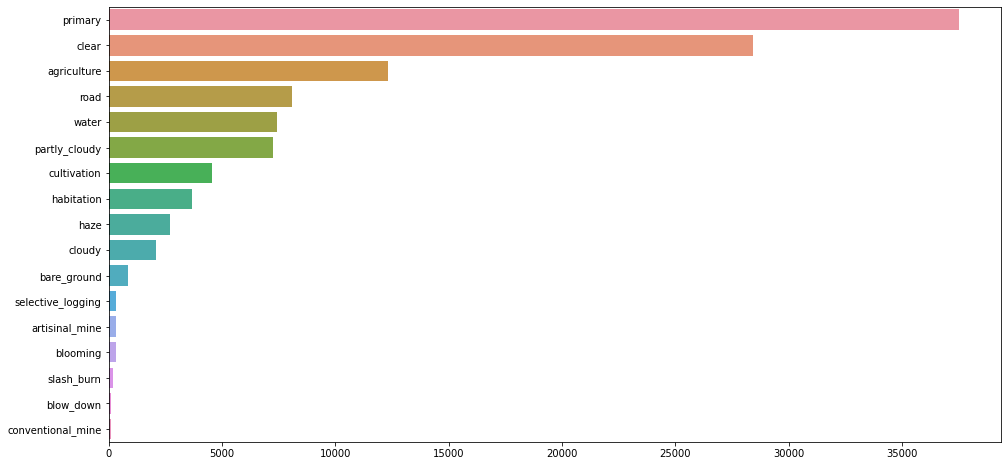

In [ ]:
import seaborn as sns
#transform the labels_list into a pandas series.
#use .value_count() to sort the series by count.
labels_s = pd.Series(labels_list).value_counts() 

#used to set the size
fig, ax = plt.subplots(figsize=(16, 8))

#use sns.barplot(x_value, y_value, orient) to plot the barplot 
sns.barplot(x = labels_s, y=labels_s.index, orient='h')


In [ ]:
#@title Run ME! { display-mode: "form" }
gdown.download(tif_url ,'tif_data.npz', True)

tif_data = np.load('tif_data.npz')
tif_images, tif_labels = tif_data['arr_0'], tif_data['arr_1']
#print(tif_images.shape)


###Excercise(Discussion):
As you can see the most frequent label is primary. Primary is used as shorthand for primary rainforest. You can also observe that the labels are ditributed unevendly. 
Does that make the task harder or easier? Why?

###Excercise: Labels Cooccurence Matrix
This project consists of a multi-label classification task. This means that not only there are multiple labels available to choose from, each image can be assigned multiple labels at the same time.
<br>When taking on a multi-label classification task, the likelihood that each label can be assigend to an image may depend on other labels. 
For example an image consisting of a habitated area is more likely than an image of primary rainforest to include roads.
<br>Let's use Seaborn and cooccurence matrices to inspect these corelations.
<br>
###To do so we first need to **one-hot encode** our labels <br>
This means that we create a dataframe where for each row coresponding to an image, a value of 0 or 1 is assigned to all the 17 labels are depending on wether or not they are in the tags for the image.

In [ ]:
# onehot encode the labels
labels_onehot = onehot_encode(set(labels_list))
labels_onehot.head()


,image_name,tags,clear,bare_ground,cloudy,habitation,cultivation,slash_burn,artisinal_mine,partly_cloudy,road,agriculture,blooming,primary,haze,water,conventional_mine,blow_down,selective_logging
0,train_0,haze primary,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
1,train_1,agriculture clear primary water,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0
2,train_2,clear primary,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,train_3,clear primary,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,train_4,agriculture clear habitation primary road,1,0,0,1,0,0,0,0,1,1,0,1,0,0,0,0,0


###Excercise(Coding):

Next step is to use the one-hot encoding of the labels and some magic matrix math to create a cooccurrence matrix for dataset labels. We can use cooccurrence matrices to understand the relationship between different labels in our dataset.
<br>Use the function **get_cooccurrence_matrix(labels_onehot, mylist)** to see how often different list of labels cooccur.
<br>Then use seaborn to create a heatmap of the matrix. This will make it easier for us to see how common cooccurences are. If two labels are more likely to cooccur, their cell will appear in a darker color.
<br> Let's examine all the labels first:

ValueError: ignored

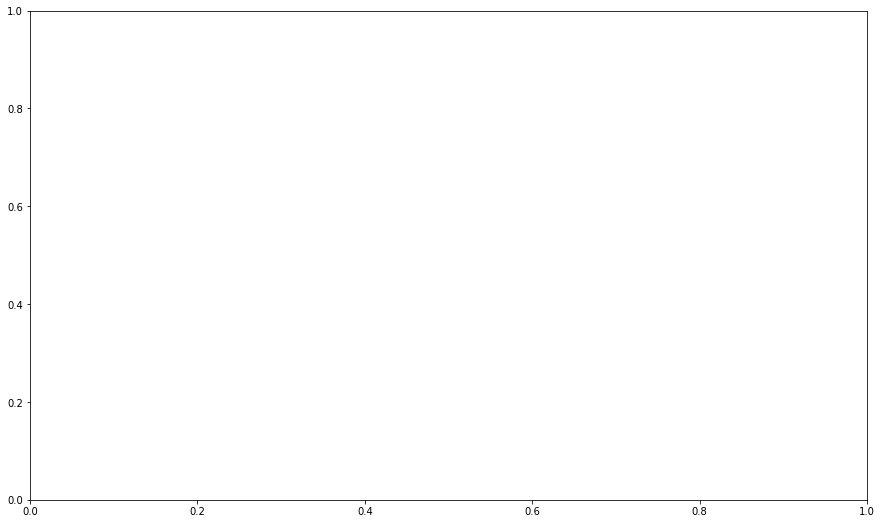

In [ ]:
# run to get the right plot size
fig, ax = plt.subplots(figsize=(15, 9))

#fill in the blanks
c_matrix = cooccurence_matrix(___,___)
sns.heatmap(____, cmap='flare')

In [ ]:
#@title Instructor solution { display-mode: "form" }
# run to get the right plot size
fig, ax = plt.subplots(figsize=(15, 9))

#fill in the blanks
c_matrix = cooccurence_matrix(labels_onehot, list(labels_set))
sns.heatmap(c_matrix, cmap='flare')

We can inspect any list of labels that might be of interest to us. 
<br> Atmospheric labels include 'clear', 'partly_cloudy', 'haze', 'cloudy'. We can use the code above to see if atmospheric labels cooccur. 
<br>Create some lists of labels and plot their cooccurrence matrices using a for loop.
<br>Make sure to create one list of the rares labels in the dataset! 


In [ ]:

lists=[]

weather_labels = ['clear', 'partly_cloudy', 'haze', 'cloudy']
lists.append(weather_labels)
list2 = [________]
lists.append(list2)
list3 = [________]
lists.append(list3)

#fill in the blanks to create a list of rare labels
rare_labels = []
for label in _______:
  if ______.sum() < 2000:
    _____________
    
lists.append(rare_labels)

#create and show c_matrix for all list of labels
for l in lists:
  fig, ax = plt.subplots(figsize=(8, 5))#change the size of the plot
  c_matrix = cooccurence_matrix(labels_onehot, l)
  sns.heatmap(c_matrix, cmap="flare")
  plt.show()



In [ ]:
#@title Instructor solution { display-mode: "form" }
lists=[]

weather_labels = ['clear', 'partly_cloudy', 'haze', 'cloudy']
lists.append(weather_labels)
list2 = ['primary', 'agriculture', 'cultivation', 'habitation']
lists.append(list2)
list3 = ['water', 'road', 'habitation']
lists.append(list3)

#fill in the blanks to create a list of rare labels
rare_labels = []
for label in labels_set:
  if labels_onehot[label].sum() < 2000:
    rare_labels.append(label)
    
lists.append(rare_labels)

#create and show c_matrix for all list of labels
for l in lists:
  fig, ax = plt.subplots(figsize=(8, 5))#change the size of the plot
  c_matrix = cooccurence_matrix(labels_onehot, l)
  sns.heatmap(c_matrix, cmap="flare")
  plt.show()



##Excercise(Discussion):

1.   Some labels are atmospheric such as 'clear', 'haze', 'cloudy'. Other labels determine how the land is being transformed by human activity. 
Why do you think each group matters to our task? 
Why do we care about categorizing the images based on their atmospheric conditions as well as land use?
2.  Inspect the heatmaps you created above. What information do they give us about each group of labels? 

<br>Take some time to go through some of the articles below and read about how each of these labels effect the amazon basin differently.<br>
[NASA's Article on Fishbone Deforestation Caused by Road Construction ](https://earthobservatory.nasa.gov/world-of-change/deforestation.php)<br>
[Roads in the Amazon](https://rainforests.mongabay.com/0814.htm#roads)<br>
[Rainforest rapidly cleared for sugarcane in Bolivia](https://https://news.mongabay.com/2016/10/exclusive-rainforest-rapidly-cleared-for-sugarcane-in-bolivia/)<br>
[NASA's article on Slash-and-burn Agriculture](https://https://earthobservatory.nasa.gov/features/AmazonFire)<br>
[Article on How Selective Logging of Valuable Trees Affects the Rainforest ](https://rainforests.mongabay.com/0807.htm)
 <!--talk about planet dataset labels here  -->


## Activity: Understanding the Images

Now that we understand how the datatset's labels are arranged, the next step is to inspect the image data.
<br>In order to do that, let's review how images are stored and manipulated in computers. 


###Activity(Review):
As we mentioned before, images are provided to us in both .jpg and .tif formats. We will discuss what the main difference is in a short while. For now, let's inspect the image datasets similarities. the datasets are stored in 'tif_images' and 'jpg_images' arrays. 
<br> Let's see what they look like.

In [ ]:
print('The "jpg_images" dataset has the type {} and dimensions {}.'.format(type(jpg_images),jpg_images.shape))
print('The "tif_images" dataset has the type {} and dimensions {}.'.format( type(tif_images), tif_images.shape))


What do you think each number means?

In [ ]:
#Fill in the code below:
print('The "jpg_image" dataset consists of {} images of height {} and width {} across {} color channels.'.format(0, 0, 0, 0))

### Excercise(Coding): Pixels

Images are stored in computers as pixel arrays. Let's use the Numpy library to access specific pixels and the Matplotlib library to plot those pixels. Use the **np.random.randint(range)** function from the Numpy library to generate three random numbers. What do these numbers mean? use the **plt.imshow(array)** function from the Matplotlib library to plot random pixels.

In [ ]:
fig, ax = plt.subplots(figsize=(4,4))#to change the size of the plot

#generate the random pixel location
image_id = np.random.randint(0,14999)
pixel_h = np.random.randint(0, 256)
pixel_w = np.random.randint(0, 256)

'''fill in the blanks'''
#grab the pixel's color channels
pixel_colors = jpg_images[______,______,______,______]
print(pixel_colors)

#create a new image consisting of 100 pixel in the same color
resized_pixel_array = np.ndarray(shape=(___,___,____), dtype='uint8')


#BEGIN YOUR CODE HERE

'''for loop to color all the pixels'''







'''show the image'''



#END YOUR CODE HERE





In [ ]:
#@title Instructor solution { display-mode: "form" }
fig, ax = plt.subplots(figsize=(4,4))#to change the size of the plot

#generate the random pixel location
image_id = np.random.randint(0,14999)
pixel_h = np.random.randint(0, 256)
pixel_w = np.random.randint(0, 256)

'''fill in the blanks'''
#grab the pixel's color channels
pixel_colors = jpg_images[image_id, pixel_h, pixel_w,:]
print(pixel_colors)
#create a new image consisting of 100 pixel in the same color
resized_pixel_array = np.ndarray(shape=(10, 10, 3), dtype='uint8')

for i in range(10):
  for j in range(10):
     resized_pixel_array[i,j] = pixel_colors

#show the image
plt.imshow(resized_pixel_array)


We can use this form of image storage to access and change a group of pixels in an image. Let's paint a portion of the image we accessed above the same color as one of its pixels. 

In [ ]:
fig, ax = plt.subplots(figsize=(16,8)) #set the size of the plot

#make a copy of the image we accessed above
jpg_copy = jpg_images[image_id,:,:,:]


#BEGIN YOUR CODE HERE
'''choose a large area and paint it'''





'''plot tht image'''



#END YOUR CODE HERE



In [ ]:
#@title Instructor solution { display-mode: "form" }

fig, ax = plt.subplots(figsize=(16,8)) #set the size of the plot

#make a copy of the image we accessed above
jpg_copy = jpg_images[image_id,:,:,:]

#choose a large area
for i in range(100, 200):
  for j in range(0, 70):
    jpg_copy[i,j] = pixel_colors

plt.imshow(jpg_copy) 


### Activity: RGBN images
As we said before, the Planet dataset provides us with both .tif and .jpg images. The main difference between the two datasets is that the .tif files contain RGBN images.
<br>RGBN images are images that have an extra layer of color composite called Nir or Near-Infra-Red. Nir color channel can display information that would normally be invisible to the human eye. 
<br>The NIR map below shows areas of highly vigorous crops in bright red and weak crops or bare soil in gray.


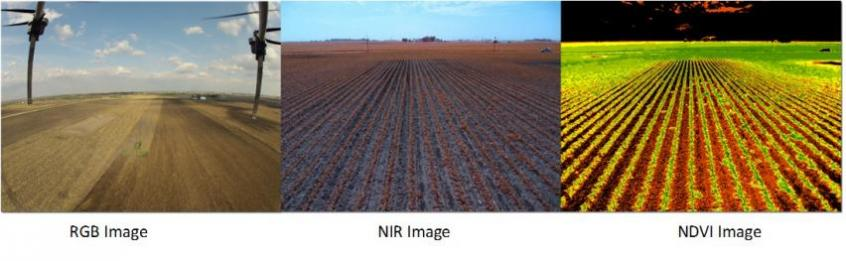


######[*Source*](https://crops.extension.iastate.edu/cropnews/2016/05/choosing-right-imagery-best-management-practices-color-nir-and-ndvi-imagery)

Let's first use the function **sample_images(n, tags_list)** to retrieve a dictionary of n images that have labels in common.
<br>This function returns a dictionary of image names as keys along with their index number as values.


In [ ]:
samples = sample_images(____,____)

In [ ]:
#@title Instructor solution { display-mode: "form" }

samples = sample_images(5, ['primary', 'water', 'road'])

Let's look at the dimensions of the images we sampled.

In [ ]:
print(samples)
for key in samples.keys():
  image_index = samples[key]
  image = tif_images[image_index, :, :, :]
  print('This image has dimensions: {}'.format(image.shape))

In [ ]:
#@title What does each number represent? { display-mode: "form" }

#@markdown What does the bold number (**256**, 256, 4) represent? 
Dimension_0  = "" #@param {type:"string"}

#@markdown What does the bold number (256, **256**, 4) represent? 
Dimension_1  = "" #@param {type:"string"}
  
#@markdown What does the bold number (256, 256, **4**) represent? 
Dimension_2  = "" #@param {type:"string"}

if 'height' in Dimension_0:
  print("Yes! Dimension_0 is the height of the image.")
else:
  print("Try again for Dimension_0!")

if 'width' in Dimension_1:
  print("Yes! Dimension_1 is the width of the image.")
else:
  print("Try again for Dimension_1!")
  
if 'color' in str(Dimension_2):
  print("Yes! Dimension_2 stands for 4 colors - (r,g,b,nir).")
else:
  print("Try again for Dimension_2!")

Let's use the Matplotlib library and the **plt.imshow(array)** fucntion to plot the RGBN images we have sampled.

In [ ]:

for key in samples.keys():
  fig, ax = plt.subplots(figsize=(6, 6)) #set the size of the plot
  #BEGIN YOUR CODE HERE







  #END YOUR CODE HERE

  


In [ ]:
#@title Instructor solution { display-mode: "form" }
for key in samples.keys():
  fig, ax = plt.subplots(figsize=(6, 6)) #set the size of the plot
  image_index = samples[key]
  image = tif_images[image_index,:,:,:]
  plt.imshow(image)


It does not look like we can inspect these images using the naked eye. Try plotting each image color channel separately using the **plt.imshow(image)**. 
<br>*Fill in the blanks.*

In [ ]:
fig, ax = plt.subplots(figsize=(22.1, 4.7)) #set the size of the plot
plt.axis('off')

#fill in the blanks to plot different color layers for the last image in our sample
for index, color in [(___,___),(___,___),(___,___),(3, 'Nir')]:
  a = fig.add_subplot(1, 4, index+1)
  a.set_title(color)
  plt.imshow(image[:,:,index])


In [ ]:
#@title Instructor solution { display-mode: "form" }
fig, ax = plt.subplots(figsize=(22.1, 4.7)) #set the size of the plot
plt.axis('off')

#fill in the blanks to plot different color layers for the last image in our sample
for index, color in [(0, 'Red'),(1, 'Green'),(2, 'Blue'),(3, 'Nir')]:
  a = fig.add_subplot(1, 4, index+1)
  a.set_title(color)
  plt.imshow(image[:,:,index])


These images seem to contain more visual information for the naked eye. We can tell that the files are not corrupted. Maybe we need to remove the Nir layer to be able to plot the .tif images.
<br>Try to write code to remove the Nir channel and plot the images we sampled above.


In [ ]:
#BEGIN YOUR CODE HERE




#END YOUR CODE HERE

In [ ]:
#@title Instructor solution { display-mode: "form" }
for key in samples.keys():
  image_index = samples[key]
  fig, ax = plt.subplots(figsize=(6, 6)) #set the size of the plot
  image = tif_images[image_index,:,:,:3]
  plt.imshow(image)

##Excercise(Discussion):
Discuss in your group: Do you think the fact that TIFF images can not be visually inspected will be an issue for an AI model that is trying to label the images? Why?

##Excercise(Coding):
<br>For an AI model the image pixel values contain all the information needed to label them. 
As a fun excercise, let's try to calibrate the .tif images so they can be visually inspected. Thankfully we have RGB images that we have successfully plotted before. 
<br>In order to understand the problem, we can plot pixel color values as a function of their location.
Use the function **plot_rgbn_histogram(r, g, b, n)** to create a color histograms for your sampled images using tif_images and jpg_images and compare.

######You can pass on zero as the nir value of JPEG images.

In [ ]:
#BEGIN YOUR CODE HERE




#END YOUR CODE HERE

In [ ]:
#@title Instructor solution { display-mode: "form" }

for key in samples.keys():
  index = samples[key]

  rgbn_image = tif_images[index,:,:,:]
  r, g, b, nir = rgbn_image[:,:,0], rgbn_image[:,:,1], rgbn_image[:,:,2], rgbn_image[:,:,3]
  plot_rgbn_histogram(r, g, b, nir)

  rgb_image = jpg_images[index,:,:,:]
  r, g, b, nir = rgb_image[:,:,0], rgb_image[:,:,1], rgb_image[:,:,2], 0
  plot_rgbn_histogram(r, g, b, nir)


###Excercise(Discussion)
Compare the RGB and the RGBN color histograms above. What do you think the problem is?

###Excercise(Coding): 
The main problem seems to be that the values for each color channel are too scattered. In statistics term, the **standard deviation ** is too big.

[video explaining standard deviation](https://www.youtube.com/watch?v=MRqtXL2WX2M
)
 <br> High standard deviation indicates that the values are spread out over a wider range. It means that the individual values are not close to the **mean**. We can write code to change the standard deviation and the mean of the color channel data.

<br> As a fun excercise we can use the .jpg images as a reference to calibrate the .tif images and plot them accurately. We will sample 100 random .jpg images and use their mean and standard deviation as a reference.
Use the following functions to get color reference values:

*  ** get_jpg_reference_colors()** returns 3 lists of values each the size of the enitre pixel area for the three color channels.
*   **np.mean(list)** and **np.std(list)** from the numpy library return mean and standard variation of the values in a list.






In [ ]:
#BEGIN YOUR CODE HERE




#END YOUR CODE HERE

In [ ]:
#@title Instructor solution { display-mode: "form" }
reference_colors = get_jpg_reference_colors()
means = [np.mean(reference_colors[i]) for i in range(3)]
SDs = [np.std(reference_colors[i]) for i in range(3)]
print('means: {}'.format(means))
print('standard deviations: {}'.format(SDs))

means: [89.06776428222656, 98.30862426757812, 85.72293090820312]
standard deviations: [5.090462864696982, 4.463929063342698, 3.3421272790875056]


Now we can define the function **calibrate_image(image)** which will change a .tif file's RBG values using the reference standard deviation and mean.

In [ ]:

fig, ax = plt.subplots(figsize=(14, 7)) #change the size of the plot

'''fill in the blanks'''

def calibrate_image(image):
  calibrated = image.copy().astype('float32')
  #ignore the Nir channel
  for i in range(3):
    #subtract image mean for each color layer from the pixel values
    ______________
    #divide by image std
    ______________
    #multiply by color reference std
    ______________
    #add color refrence mean
    ______________
    #make sure pixel values are in the proper range
    ______________

  return calibrated.astype('uint8')
  
'''calibrate the sample .tif images and plot them'''
#BEGIN YOUR CODE HERE


#END YOUR CODE HERE



In [ ]:
#@title Instructor solution { display-mode: "form" }

fig, ax = plt.subplots(figsize=(14, 7)) #change the size of the plot

'''fill in the blanks'''

def calibrate_image(image):
  calibrated = image.copy().astype('float32')
  #ignore the Nir channel
  for i in range(3):
    #subtract image mean for each color layer from the pixel values
    calibrated[:,:,i] = calibrated[:,:,i] - np.mean(calibrated[:,:,i])
    #divide by image std
    calibrated[:,:,i] = calibrated[:,:,i] / np.std(calibrated[:,:,i])
    #multiply by color reference std
    calibrated[:,:,i] = calibrated[:,:,i] * SDs[i]
    #add color refrence mean
    calibrated[:,:,i] = calibrated[:,:,i] + means[i]
    #make sure pixel values are in the proper range
    calibrated[:, :, i] = np.clip(calibrated[:, :, i], 0, 255)

  return calibrated.astype('uint8')
  
'''calibrate the sample .tif images and plot them'''
for key in samples.keys():
  index = samples[key]
  my_image = tif_images[103,:,:,:3]
  calibrated_image = calibrate_image(my_image)
  plt.imshow(calibrated_image)



# Milestone 2. Choosing the Right Evaluation Metric

Choosing the right metric is crucial while evaluating machine learning models. In this section we will discuss the appropriate measurement metric for the task of classifying human activity in the amazon basin based on satellite images.

In this project our model is expected to complete a multi-label classification task. 

In a binary classification task we mainly are interested in True Positives,True Negatives, False Positives and False Negatives.



In [ ]:
#@title Fill in the blanks!{ display-mode: "form" }
#@markdown Suppose we are only interested to see if 7 pictures from our dataset are labeled as
#@markdown primary rainforest "primary" or not. 
#@markdown True_labels = {1, 1, 1, 0, 0 , 1, 0, 1}
#@markdown model_guesses = {0, 1, 1, 1, 1, 0, 0, 1}
#@What are the following values?

true_positive  = "" #@param {type:"string"}
 
true_negative  = "" #@param {type:"string"}
  
false_positive  = "" #@param {type:"string"}

false_negative  = "" #@param {type:"string"}

all = [1 for i in range(3)]
if true_positive != "3" :
  print("Try again for true_positives!")
  all[0]=0

if true_negative != "1":
  print("Try again for true_negatives!")
  all[1]=0

if false_positive != "2":
  print("Try again for true_positives!")
  all[2]=0

if false_negative != "2":
  print("Try again for true_positives!")
  all[3]=0

if 0 not in all:
  print('Good job!')



## Discussion: 

There are many ways of combining these values to evaluate a machine learning model. 

<br> *Percision* is a metric name that is used to describe **(true positives)/(false positives+true positives)** In other words when a label is assigned what is the likelihood that the area is correctly labeled by the model.

<br> *accuracy* is a more general metric name that is used to describe **true positives + true negatives / (true negatives + true positives + false negatives + false positives)** In other words how likely the model is to make a mistake.

<br> *Recall* is a metric name used to describe **true positives/(false negatives + true positives)**. In other words what percentage of the phenomena that exist in the area were correctly guessed. 

###Discuss : 
* Are we interested in the percision of our model in this task? why?
* Are we interested in recall? why?

* By optimizing for accuracy, which undesirable outcome do we minimize?
* What about recall?






##Activity: Let's Choose a Metric!

As you have probably already guessed, in this problem, we value both the percision and recall. 

For our purposes, there exist a catergory of evlauation metrics called f-beta scores. These metrics combine the values for percision and recall and give us the flexibility to decide howmuch value we want to put on each when developing and evaluating our model. 


F-β = (1 + β^2) x (precision * recall) / (β^2 * precision + recall)

β is the constant. We can change it to effect the weight given to recall and percision in the calculation of the F-β score.

###Discuss in your groups:

Based on the last discussion section, the task at hand, project stakeholders, and the dataset what should the F-β score put more weight on the percision or the recall?








##Bonus: 

In the past we have worked with binary classification tasks. Caluclating True and False Positive and Negative values in a binary classification task is a fairly staright forward task. 
There are multiple ways of caluclating these values across multiple labels including averaging TP, TN, FP, FN values for each label class or giving every single lable prediction equal weight. 
###Review: 
Run the cell below to replot the label bargraph from the beginning of this notebook.


In [ ]:
#transform the labels_list into a pandas series.
#use .value_count() to sort the series by count.
labels_s = pd.Series(labels_list).value_counts() 

#used to set the size
fig, ax = plt.subplots(figsize=(16, 8))

#use sns.barplot(x_value, y_value, orient) to plot the barplot 
sns.barplot(x = labels_s, y=labels_s.index, orient='h')


* What information about label distribution can you extract from this plot?


In [ ]:
#@title Fill in the blanks!{ display-mode: "form" }
#@markdown **The more examples of a phenomenon an ML model encounters, the easier it will be for the model 
#@markdown to guess the correct label next time the same phenomenon is present in an image.** <br> When
#@markdown calculating TP, TN, TF, TN values, if we give '_____________________________' 
#@markdown the same weight, our model evaluation metric might measure the model's success at classifying
#@markdown '_____________________________'. <br> If we give the same weight to '_____________________' when calculating TP, TN, TF, TN values,
#@markdown there is a chance that the our model evaluation metric puts unnecessary weight on '_________________' if the rare labels belong to 
#@markdown phenomenon that are rare to find in reality.

blankspace_1 = "fill in" #@param ["each indiviual label prediction(micro-averaging)","label class predictions(macro-averaging)","rare labels such as conventional_mine","more common labels such as primary","fill in"]
blankspace_2 =  "fill in" #@param ["label class predictions(macro-averaging)","each indiviual label prediction(micro-averaging)","rare labels such as conventional_mine","more common labels such as primary","fill in"]
blankspace_3 = "fill in" #@param ["label class predictions(macro-averaging)","each indiviual label prediction(micro-averaging)","rare labels such as conventional_mine","more common labels such as primary","fill in"]
blankspace_4 =  "fill in"#@param ["label class predictions(macro-averaging)","each indiviual label prediction(micro-averaging)","rare labels such as conventional_mine","more common labels such as primary","fill in"]




The Planet dataset has been the subject of a competition on [Kaggle](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/data) in which data compilers have decided that the best metric for the evaluation of multi-label classification of the images is the F-2 score. The F-2 score is a version of the F-β score in which Recall is weighted twice as much as Percision. 
In the next notebook we will use the f-beta score to measure the performance of the models we design.





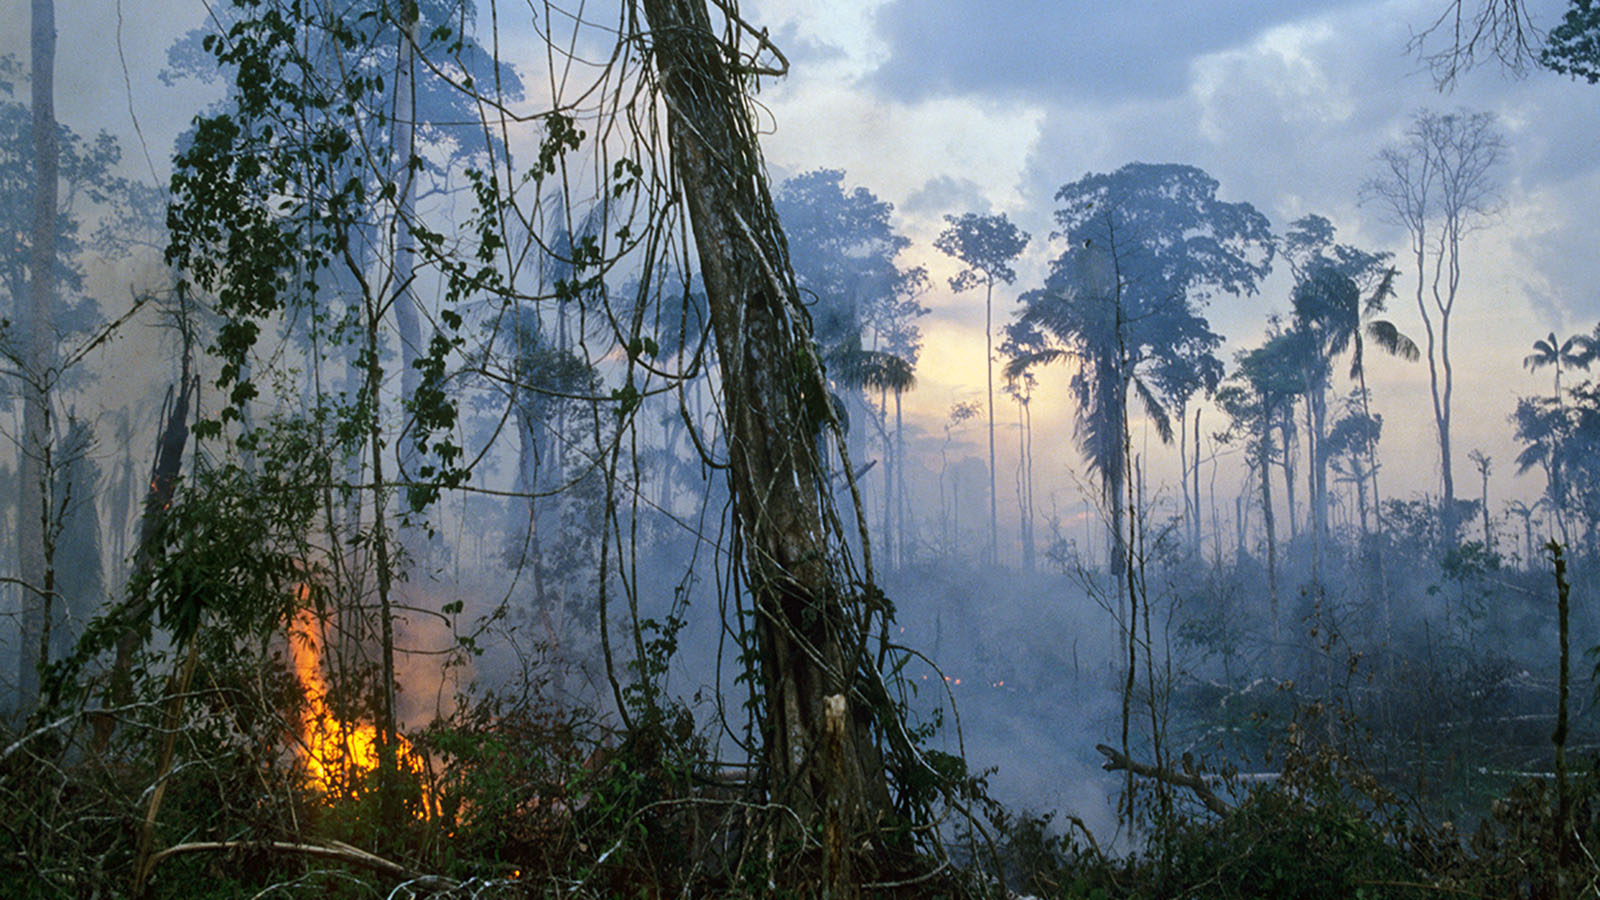

In [ ]:
#@title Run this to download data and prepare our environment! { display-mode: "form" }
import sys
import os
import subprocess
from skimage import io

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy
from scipy import ndimage
from IPython.display import display

from collections import Counter 
from itertools import repeat, chain 

from PIL import Image
import gdown

%matplotlib inline


jpg_url = 'https://drive.google.com/uc?id=12YD_yMcukg3ko5lo4fVtz4dTzqjGUZZN'
tif_url = 'https://drive.google.com/uc?id=1tevqyGnvpctZHd4N6zTzE2Cu8AA6dN-R'
labels_url= 'https://drive.google.com/uc?id=1VTHKiNkH5LU61qy87FS_Eqod2EgaoAwM'


gdown.download(jpg_url ,'jpg_data.npz', True)
# gdown.download(tif_url ,'tif_data.npz', True)
gdown.download(labels_url ,'labels.csv', True)


jpg_data = np.load('jpg_data.npz')
jpg_images, jpg_labels = jpg_data['arr_0'][:5000,:], jpg_data['arr_1'][:5000,:]


def find_all_labels(df):
  labels_list = list(chain.from_iterable([tags.split(" ") for tags in df['tags'].values]))
  labels_list = list(chain.from_iterable(repeat(i, c) 
          for i, c in Counter(labels_list).most_common()))
  return labels_list


#Milestone 3. Machine Learning

Before we can jump into creating models that are good at recognizing pattern in visual data such as CNN, we should get a sense of what constitutes a good F-2 score for this task by devising a more preliminary model. 

Planet's original dataset, labels each image using one tag that contains several labels. Let's take a look:

In [ ]:
 labels_df = pd.read_csv('labels.csv')
 labels_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In order to separate the labels, we can use a onehot encoded labels array. We have saved such an array in the form of a numpy array for you. Run this cell to take a look. This will be our target. We are hoping our AI system will be good at replicating this array just by analyzing the images associated with each row. 




In [ ]:
jpg_labels
print(jpg_images.shape)

(5000, 128, 128, 3)


We have created many different machine learning models before. Next, we will try and devise a K-Nearest Neighbor model, train it on training data and use f_beta score function to see what might be a minimally acceptable F-2 score. Sklearn provides helpful functions for splitting the data into test, 
<br>**train_test_split(flattened_images, image_labels, test_size, random_state=1)**. 
<br>
**KNeighborsClassifier(n)** where n is the number of neighbors 
<br> **fbeta_score(train_labels, predictions, β , average='samples')** which returns the fbeta_score as a percentage. what should β be? 


In [ ]:

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import fbeta_score
from sklearn.model_selection import train_test_split


d1, d2, d3, d4 = jpg_images.shape
flattened_images = jpg_images.reshape((d1, d2*d3*d4))


'''fill in the blank'''
trainX, testX, trainY, testY = ___________________


'''train KNN model, and get fbeta score for jpg_images'''
#BEGIN YOUR CODE HERE




#END YOUR CODE HERE



[[0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 1]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]]
(5000, 128, 128, 3)
(1500, 49152)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
0.6916754651567784


In [ ]:
#@title Instructor solution! { display-mode: "form" }

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import fbeta_score
from sklearn.model_selection import train_test_split


d1, d2, d3, d4 = jpg_images.shape
flattened_images = jpg_images.reshape((d1, d2*d3*d4))

trainX, testX, trainY, testY = train_test_split(flattened_images, jpg_labels, test_size=0.3, random_state=1)
print(trainY)
print(jpg_images.shape)
print(testX.shape)


knn = KNeighborsClassifier(5)
knn.fit(trainX, trainY)
predictions = knn.predict(testX)
print(predictions)
score = fbeta_score(testY, predictions, 2, average='samples')

print(score)




[[0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 1]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]]
(5000, 128, 128, 3)
(1500, 49152)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
0.6916754651567784
